### Monte Carlo DLA

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random

In [23]:
class MonteCarloWalker:
    def __init__(self, grid):
        x_list = range(1, len(grid) - 1)       # Random location in the x-axis
        x_pos = np.random.choice(x_list)      
        self.pos = np.array([x_pos, 1])  # Starts at top boundary
        self.present = True
        self.grid = grid
        self.gridSize = len(grid) - 1

    def remove(self):
        self.present = False

    def step(self):
        possible_steps = [(1, 0), (0, 1), (-1, 0), (0, -1)]
        x_step, y_step = random.choice(possible_steps)
        # Update grid position
        self.pos += np.array([x_step, y_step])

        # Conditions in the x-direction
        if self.pos[0] > self.gridSize - 1: # Reaches right boundary
            self.pos[0] = 1
        if self.pos[0] < 1: # Reaches left boundary
            self.pos[0] = self.gridSize - 1

        # Conditions in the y-direction
        if self.pos[1] > (self.gridSize - 1) or self.pos[1] < 1:   # Reaches top or bottom 
            self.remove()
            self.__init__(self.grid)

    def check_neighbor(self):
        i,j = self.pos
        neighbors = self.grid[i - 1, j] + self.grid[i + 1, j] + self.grid[i, j + 1] + self.grid[i, j - 1]
        neighbors_present = neighbors > 0
        return neighbors_present

    def merge_cluster(self, sticky_p = 1):
        if np.random.uniform() < sticky_p:
            self.grid[self.pos[0], self.pos[1]] = 1
            self.remove()
        else: self.step()
        return self.grid
        

In [24]:
def random_walk(grid, sticky_p=1):
        randomWalker = MonteCarloWalker(grid)
        while randomWalker.present:
            if randomWalker.check_neighbor():
                grid = randomWalker.merge_cluster(sticky_p)
            randomWalker.step()
        return grid

def simulate_walks(grid, steps, sticky_p=1):
    for n in range(steps):
        grid = random_walk(grid, sticky_p)
    return grid

def init_grid(gridSize=100):
    grid = np.zeros((gridSize + 2, gridSize + 2))
    grid[gridSize//2, gridSize-2] = 1   # Inserting object
    # grid[:, -2] = 1 # Initiating the grid (IS SOURCE NECESSARY??)
    grid[gridSize//2, 0] = 0
    return grid

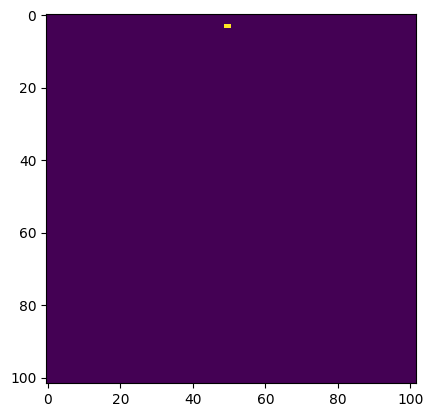

In [32]:
single_waker = random_walk(init_grid())
plt.imshow(np.rot90(single_waker))

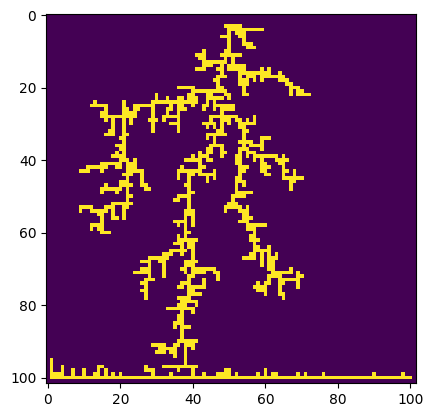

In [26]:
num_steps = 100_000
many_walks = simulate_walks(init_grid(), num_steps, 1)
plt.imshow(np.rot90(many_walks))

In [27]:
# Testing sticky p
sticky_1 = simulate_walks(init_grid(), num_steps, 0.5)
sticky_2 = simulate_walks(init_grid(), num_steps, 0.2)
sticky_3 = simulate_walks(init_grid(), num_steps, 0.1)

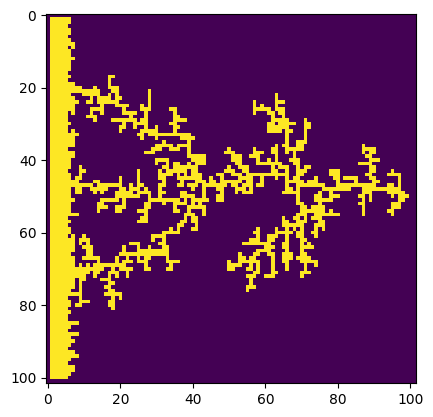

In [28]:
plt.imshow(sticky_1)

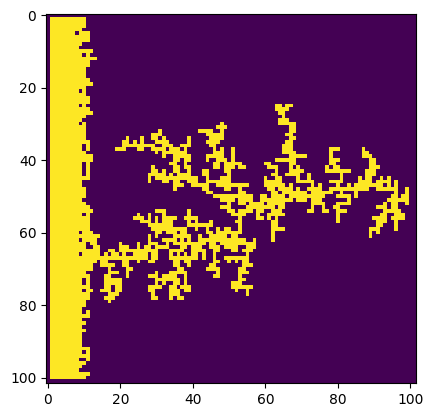

In [29]:
plt.imshow(sticky_2)

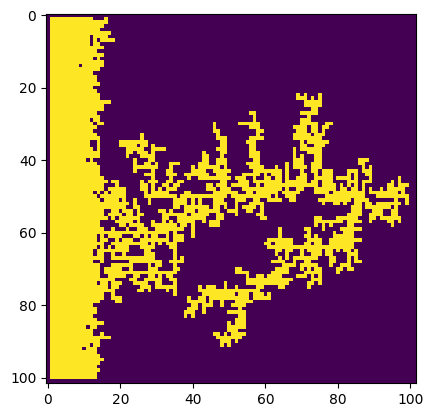

In [30]:
plt.imshow(sticky_3)